In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Sequence_706/neural_transfer_code

Mounted at /content/drive
/content/drive/MyDrive/Sequence_706/neural_transfer_code


In [2]:
!pip install wandb
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from IPython.display import display
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import wandb
import yaml

import vgg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.3 MB/s eta 0:00:00


In [3]:
with open("config.yaml", 'r') as file:
    settings = yaml.safe_load(file)

# Hyerparameters
total_steps = 16
img_savepoint = 4
learning_rate = settings["learning_rate"]
content_weight = settings["content_weight"]
style_weight = settings["style_weight"]
path = settings["path"]
imsize = settings["imsize"]
style_images = settings["style_images"]
content_image = settings["content_image"]
style_loss_type = settings["style_loss_type"]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loader = transforms.Compose(
    [
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor(),
    ]
)

def load_image(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device)

def load_checkpoint(file_name, optimizer, generated_path=None, device=None):
    if not device:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ckpt = torch.load(file_name, map_location=device)
    optimizer.load_state_dict(ckpt['optimizer_state'])
    print("Optimizer's state loaded!")
    generated = None
    if generated_path:
        generated = load_image(generated_path)
    print("Generated image loaded!")
    return generated

In [5]:
content_img = load_image(f"pictures/{content_image}")
style_imgs = [load_image(f"pictures/{img}") for img in style_images]

generated = content_img.clone().requires_grad_(True)
optimizer = optim.LBFGS([generated])

In [6]:
model = vgg.VGG().to(device).eval()
# Do not load previously generated image, we will start from new content image
load_checkpoint("checkpoints/vgg-19-2_ckpt_step_finished.pth", optimizer)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 93.3MB/s]


Optimizer's state loaded!
Generated image loaded!


Using GRAM for style loss
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


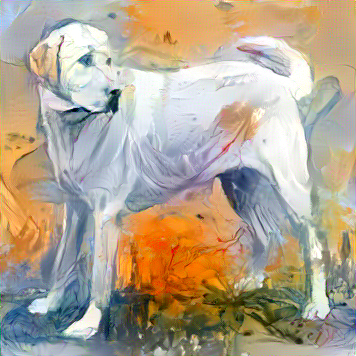

In [7]:
def covariance_matrix(features):
    batch_size, channel, height, width = features.size()
    features = features.view(channel, height * width)
    mean = features.mean(1, keepdim=True)
    cov = (features - mean).mm((features - mean).t()) / (height * width - 1)
    return cov

def vincent_loss(generated_feature, style_feature):
    gen_cov = covariance_matrix(generated_feature)
    style_cov = covariance_matrix(style_feature)
    return torch.mean((gen_cov - style_cov) ** 2)

if style_loss_type.lower() == "gram":
    print("Using GRAM for style loss")
else:
    print("Using Vincent's for style loss")

for step in range(total_steps):
    print(step)
    def closure():
        optimizer.zero_grad()
        generated_features = model(generated)
        content_img_features = model(content_img)
        style_imgs_features = [model(style_img) for style_img in style_imgs]

        style_loss = content_loss = 0

        # iterate through all the features for the chosen layers
        for gen_feature, cont_feature, style_features in zip(
            generated_features, content_img_features, list(map(list, zip(*style_imgs_features)))
        ):

            # batch_size will just be 1
            batch_size, channel, height, width = gen_feature.shape
            content_loss += torch.mean((gen_feature - cont_feature) ** 2)

            if style_loss_type.lower() == "gram":
                # Compute Gram Matrix of generated
                G = gen_feature.view(channel, height * width).mm(
                    gen_feature.view(channel, height * width).t()
                )
                # Compute Gram Matrix of Style
                for style_feature in style_features:
                    A = style_feature.view(channel, height * width).mm(
                        style_feature.view(channel, height * width).t()
                    )
                    style_loss += torch.mean((G - A) ** 2)
            else:
                # Compute Vincent's Loss
                for style_feature in style_features:
                    style_loss += vincent_loss(gen_feature, style_feature)

        style_loss = style_loss / len(style_imgs)

        total_loss = content_weight * content_loss + style_weight * style_loss

        if step + 1 % img_savepoint == 0:
            print(f"Style loss: {style_loss}")
            print(f"Content loss: {content_loss}")
            print(f"Total weighted loss:{total_loss}")

        total_loss.backward()
        return total_loss

    optimizer.step(closure)

display(Image.open(path))